In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import subprocess
import os
import random
import math
import time

import rdkit
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import rdmolops
from rdkit import DataStructs
from rdkit.Chem import AllChem
from rdkit.ML.Cluster import Butina

# shut off warnings
from rdkit import RDLogger                                                                                                                                                               
RDLogger.DisableLog('rdApp.*')  

from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
from IPython.display import SVG
from copy import deepcopy

RDKit WARNING: [17:44:40] Enabling RDKit 2019.09.1 jupyter extensions
[17:44:40] Enabling RDKit 2019.09.1 jupyter extensions


In [2]:
kill_df = pd.read_csv('../out/2I_interpretation_results_killing.txt', sep = '\t')
inh_df = pd.read_csv('../out/2I_interpretation_results_inhibit.txt', sep = '\t')

# Process the csv produced by the rationale algorithm
def proc_interpret_df(df, name):
    orig_smis = []
    orig_scores = []
    rationale_smis = []
    rationale_scores = []
    
    for i, line in df.iterrows():
        line = list(line)[0]
        if ('Loading pretrained' in line) or ('Moving model' in line) or ('rationale_score' in line) or ('Elapsed time' in line):
            continue
        line = line.split('\'')
        orig_smi = line[1]
        rest = line[2].split(',')
        orig_sco = rest[1]
        rationale_smi = rest[2]
        rationale_sco = rest[3]
        
        orig_smis.append(orig_smi)
        orig_scores.append(orig_sco)
        rationale_smis.append(rationale_smi)
        rationale_scores.append(rationale_sco)
        
    newdf = pd.DataFrame()
    newdf['original_mol'] = orig_smis
    newdf['orig_' + name + '_score'] = orig_scores
    newdf[name + '_rationale'] = rationale_smis
    newdf[name + '_rationale_score'] = rationale_scores
    
    return(newdf)
        
kill_df = proc_interpret_df(kill_df, 'kill')
inh_df = proc_interpret_df(inh_df, 'inh')

merged_df = kill_df.merge(inh_df, on = 'original_mol')

meta_df = pd.read_csv('../out/data_prep_for_ml_fullset.csv')
merged_df = merged_df.merge(meta_df, left_on = 'original_mol', right_on = 'SMILES')
merged_df

,original_mol,orig_kill_score,kill_rationale,kill_rationale_score,orig_inh_score,inh_rationale,inh_rationale_score,SMILES,Name,hit_inh,hit_kill
0,CCCC[C@H](CC)CNC(=N)N=C(N)NCCCCCCNC(N)=NC(=N)N...,0.741,N=C(N=[CH:1]NCC[CH3:1])[NH2:1],0.125,0.735,N=C(N=[CH:1]NCC[CH3:1])[NH2:1],0.237,CCCC[C@H](CC)CNC(=N)N=C(N)NCCCCCCNC(N)=NC(=N)N...,alexidine,1.0,1.0
1,NC(Nc1ccc(Cl)cc1)=NC(=N)NCCCCCCNC(=N)N=C(N)Nc1...,0.432,C(CCC[NH2:1])CCN[CH3:1],0.241,0.322,N=C(N=[CH:1]N[CH3:1])NCC[CH3:1],0.104,NC(Nc1ccc(Cl)cc1)=NC(=N)NCCCCCCNC(=N)N=C(N)Nc1...,chlorhexidine,1.0,1.0
2,CC[C@@H](C)CCCCC(=O)N[C@@H](CCN)C(=O)N[C@@H]([...,0.614,,,0.719,,,CC[C@@H](C)CCCCC(=O)N[C@@H](CCN)C(=O)N[C@@H]([...,polymyxin-B-sulfate,1.0,1.0
3,OCCN[C@H]1CCCc2c1[nH]c1ccc(cc21)-c1ccccc1 |&1:...,0.099,,,0.049,,,OCCN[C@H]1CCCc2c1[nH]c1ccc(cc21)-c1ccccc1 |&1:...,casin,1.0,1.0
4,NC[C@H]1O[C@H](O[C@@H]2[C@@H](N)C[C@@H](N)[C@H...,0.147,,,0.177,,,NC[C@H]1O[C@H](O[C@@H]2[C@@H](N)C[C@@H](N)[C@H...,bekanamycin,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
74,CCn1cc(C(O)=O)c(=O)c2cc(F)c(cc12)N1CCNCC1,0.424,O=c1c2cc(F)[cH:1]cc2n([CH3:1])c[cH:1]1,0.119,0.840,O=c1c2cc(F)[cH:1]cc2n([CH3:1])c[cH:1]1,0.163,CCn1cc(C(O)=O)c(=O)c2cc(F)c(cc12)N1CCNCC1,norfloxacin,1.0,1.0
75,C1CCC(CC1)c1ccc2n3CCNC4CCCc(c34)c2c1,0.419,c1c[cH:1]cc2c3c4n(c12)CCNC4CCC3,0.181,0.406,C1Cc2c3n([cH:1][cH:1]2)CCNC3C1,0.107,C1CCC(CC1)c1ccc2n3CCNC4CCCc(c34)c2c1,tetrindole,1.0,1.0
76,CN1CCN(CC1)c1cc2n(cc(C(O)=O)c(=O)c2cc1F)-c1ccc...,0.425,O=c1c2cc(F)[cH:1]cc2n([CH3:1])c[cH:1]1,0.119,0.759,O=c1c2cc(F)[cH:1]cc2n([CH3:1])c[cH:1]1,0.163,CN1CCN(CC1)c1cc2n(cc(C(O)=O)c(=O)c2cc1F)-c1ccc...,difloxacin,1.0,1.0
77,OC(=O)c1cn(-c2ccc(F)cc2)c2cc(N3CCNCC3)c(F)cc2c1=O,0.515,O=c1c2cc(F)[cH:1]cc2n([CH3:1])c[cH:1]1,0.119,0.787,O=c1c2cc(F)[cH:1]cc2n([CH3:1])c[cH:1]1,0.163,OC(=O)c1cn(-c2ccc(F)cc2)c2cc(N3CCNCC3)c(F)cc2c1=O,sarafloxacin,1.0,1.0


In [3]:
# code from https://stackoverflow.com/questions/69735586/how-to-highlight-the-substructure-of-a-molecule-with-thick-red-lines-in-rdkit-as

def increase_resolution(smi_big, smi_substr, size=(400, 200), kekulize=True, legend = ''):
    mol = Chem.MolFromSmiles(smi_big)
    substructure = Chem.MolFromSmiles(smi_substr)
    mol = deepcopy(mol)
    substructure = deepcopy(substructure)
    rdDepictor.Compute2DCoords(mol)
    if kekulize:
        Chem.Kekulize(mol, clearAromaticFlags=True) # Localize the benzene ring bonds
        Chem.Kekulize(substructure, clearAromaticFlags=True)
        
        mol = Chem.RemoveHs(mol, sanitize=True)
        substructure = Chem.RemoveHs(substructure, sanitize=True)
        
    drawer = rdMolDraw2D.MolDraw2DSVG(size[0], size[1])
    
    # manually correct those that aren't being properly highlighted
    corrections_dict = {'Cc1cc(ccc1OCCOCC[N+](C)(C)Cc1ccccc1)C(C)(C)CC(C)(C)C.C[N+:1](Cc1ccccc1)[CH3:1]': (13, 14, 15, 16, 17, 18, 19, 20, 21, 22),
                       'CNC[C@@H]1CC[C@@H](N)[C@@H](O[C@@H]2[C@@H](N)C[C@@H](N)[C@H](O[C@H]3OC[C@](C)(O)[C@H](NC)[C@H]3O)[C@H]2O)O1.N[C@H]1C[C@@H](N)[C@H](O[C@H]2OC[C:1][C@H]([NH2:1])[CH2:1]2)[C@@H](O)[CH2:1]1': (10,11,12,13,14,15,16,17,18,19,20,21,24,25,27,29,30),
                       'CCCCCCCCCCCCC[N+](C)(C)Cc1ccccc1.C[N+:1](CCCCC[CH3:1])[CH3:1]': (7,8,9,10,11,12,13,15,16),
                       'CCCCCCCCCCCCC[N+](C)(C)Cc1ccccc1.C[N+:1]CCCCCC[CH3:1]': (6,7,8,9,10,11,12,13,16),
                       'CCCCCCCCCCCCCCCC[N+](C)(C)C.C[N+:1](C)CCCCC[CH3:1]':(10,11,12,13,14,15,16,18,19),
                       'CCCCCCCCCCCCCCCC[N+](C)(C)C.C[N+:1]CCCCCC[CH3:1]':(9,10,11,12,13,14,15,16,19),
                        'CCCCCCCCCCCCCCCC[N+](C)(C)Cc1ccccc1.C[N+:1](CCCCC[CH3:1])[CH3:1]':(10,11,12,13,14,15,16,18,19),
                        'CCCCCCCCCCCCCCCC[N+](C)(C)Cc1ccccc1.C[N+:1]CCCCCC[CH3:1]':(9,10,11,12,13,14,15,16,19),
                        'CCCCCCCCCCCC[N+](C)(C)CCOc1ccccc1.C[N+:1](CCCCC[CH3:1])[CH3:1]':(6,7,8,9,10,11,12,14,15),
                        'CCCCCCCCCCCC[N+](C)(C)CCOc1ccccc1.C[N+:1]CCCCCC[CH3:1]':(5,6,7,8,9,10,11,12,15),
                        'CC(C)(C)CC(C)(C)c1ccc(OCCOCC[N+](C)(C)Cc2ccccc2)cc1.C[N+:1](Cc1ccccc1)[CH3:1]':(18,19,20,21,22,23,24,25,26,27),
                        'CC1=C(C)C(=O)C(CCCCCCCCCC[P+](c2ccccc2)(c2ccccc2)c2ccccc2)=CC1=O |c:1,38|.C(CC[CH3:1])CC[P+:1]([CH3:1])[CH3:1]':(11,12,13,14,15,16,17,24,30),
                        'CC1=C(C)C(=O)C(CCCCCCCCCC[P+](c2ccccc2)(c2ccccc2)c2ccccc2)=CC1=O |c:1,38|.C(CCC[P+:1][CH3:1])CC[CH3:1]':(10,11,12,13,14,15,16,17,18),
                        'Cc1ccc(cc1)-c1ccc2CCCC(=Cc2c1)C(=O)Nc1ccc(C[N+](C)(C)C2CCOCC2)cc1 |c:15|.C[N+:1]Cc1ccc([NH2:1])cc1':(20,21,22,23,24,25,26,29,35,36),
                        'CO[C@]12[C@H]3N[C@H]3CN1C1=C([C@H]2COC(N)=O)C(=O)C(N)=C(C)C1=O |c:10,t:22|.O=C1C2=C(C(=O)[CH:1]=[CH:1]1)[CH2:1][C:1]1[C@H]3N[C@H]3CN21':(2,3,4,5,6,7,8,9,10,15,16,17,18,20,22,23),
                        'CO[C@]12[C@H]3N[C@H]3CN1C1=C([C@H]2COC(N)=O)C(=O)C(N)=C(C)C1=O |c:10,t:22|.O=C1C2=C(C(=O)[CH:1]=[CH:1]1)[NH:1][C:1][CH2:1]2':(2,10,7,8,9,16,17,18,20,22,23),
                        'CC(C)[C@H]1CC[C@H](C)C[C@@H]1OC(=O)C[N+](C)(C)CCCCCCCCCC[N+](C)(C)CC(=O)O[C@H]1C[C@H](C)CC[C@@H]1C(C)C |&1:40,&2:36,&3:34,&4:9,&5:6,&6:3|.C[N+:1](CCCCC[CH3:1])[CH3:1]':(13,14,16,17,18,19,20,21,22,23,24,25,26,27,28,30),
                        '[O-][N+](=O)c1ccc2C=CS(=O)(=O)c2c1 |c:7|.O=S1(=O)C=Cc2ccc([N+:1])cc21':(1,3,4,5,6,7,8,9,10,11,12,13),
                        'COC1=C(OC)C(=O)C(CCCCCCCCCC[P+](c2ccccc2)(c2ccccc2)c2ccccc2)=C(C)C1=O |c:2,t:40|.C(CC[CH3:1])CC[P+:1]([CH3:1])[CH3:1]':(13,14,15,16,17,18,19,26,32),
                        'COC1=C(OC)C(=O)C(CCCCCCCCCC[P+](c2ccccc2)(c2ccccc2)c2ccccc2)=C(C)C1=O |c:2,t:40|.C(CCC[P+:1][CH3:1])CC[CH3:1]':(12,13,14,15,16,17,18,19,20),
                        '[H][C@@]12Cc3c(F)cc(NC(=O)CN4CCCC4)c(O)c3C(=O)[C@H]1C(=O)[C@]1(O)C(=O)[C@H](C(N)=O)C(=O)[C@@H](N(C)C)[C@]1([H])C2 |&1:29,&2:22|.C[NH:1][C@@H]1C(=O)[C@@H]([CH:1]=O)C(=O)[C:1][CH2:1]1':(24,26,27,28,29,31,32,33,34,35,36,38),
                        'CCCCCCCCCCCCCCCC[N+](C)(C)CC.C[N+:1](CCCCC[CH3:1])[CH3:1]':(10,11,12,13,14,15,16,18,19,),
                        'CCCCCCCCCCCCCCCC[N+](C)(C)CC.C[N+:1]CCCCCC[CH3:1]':(9,10,11,12,13,14,15,16,19),
                        'CN(C)c1ccc(cc1)[C+](c1ccc(cc1)N(C)C)c1ccc(cc1)N(C)C.CN(C)c1ccc([C+:1]c2ccc([NH2:1])cc2)cc1':(0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27),
            }
    # highlightAtoms expects only one tuple, not tuple of tuples. So it needs to be merged into a single tuple
    matches = sum(mol.GetSubstructMatches(substructure), ())
    mod_smi = smi_big + '.' + smi_substr
    if len(matches) == 0:
        if mod_smi in corrections_dict:
            matches = corrections_dict[mod_smi]
        #else:
            #print(smi_big)
            #print(smi_substr)
            
    drawer.DrawMolecule(mol, highlightAtoms=matches, legend = legend)
    
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    return svg.replace('svg:','')


-----------------------------------------------------------------------
alexidine , actual kill:  1.0 , actual inh:  1.0


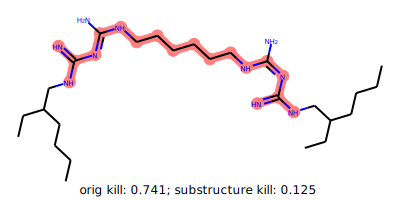

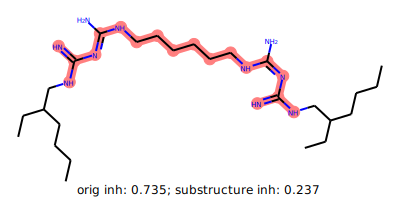


-----------------------------------------------------------------------
chlorhexidine , actual kill:  1.0 , actual inh:  1.0


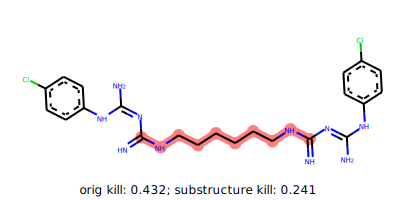

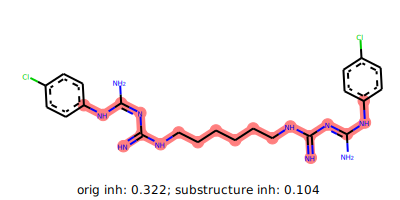


-----------------------------------------------------------------------
methylbenzethonium-chloride , actual kill:  1.0 , actual inh:  1.0


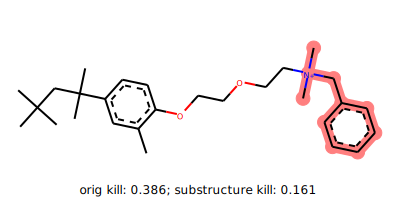

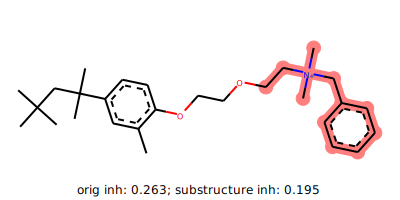


-----------------------------------------------------------------------
micronomicin , actual kill:  1.0 , actual inh:  1.0


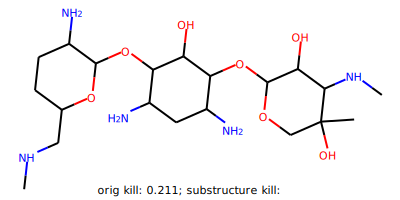

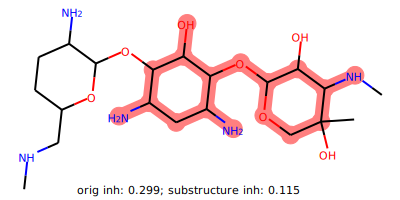


-----------------------------------------------------------------------
benzalkonium , actual kill:  1.0 , actual inh:  1.0


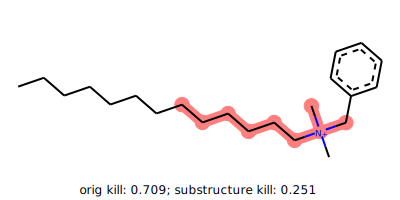

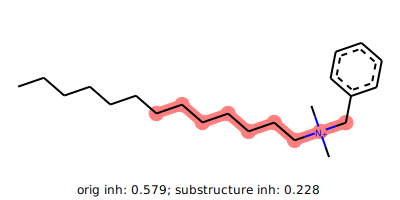


-----------------------------------------------------------------------
dichlorophen , actual kill:  1.0 , actual inh:  1.0


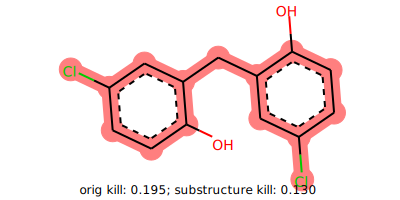

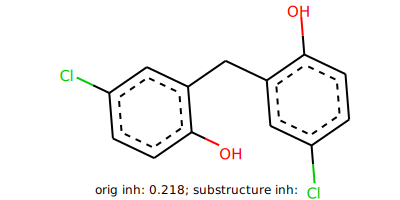


-----------------------------------------------------------------------
cetrimonium , actual kill:  1.0 , actual inh:  1.0


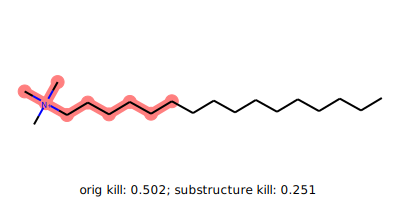

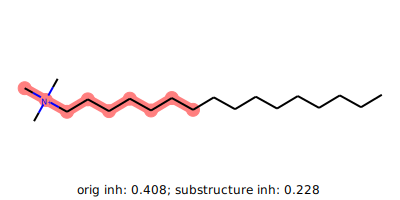


-----------------------------------------------------------------------
fingolimod , actual kill:  1.0 , actual inh:  1.0


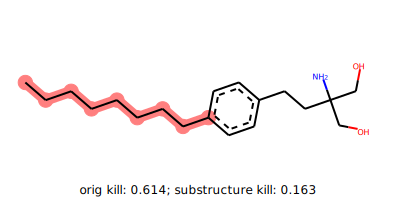

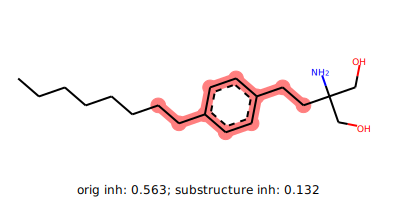


-----------------------------------------------------------------------
benzyldimethylhexadecylammonium , actual kill:  1.0 , actual inh:  1.0


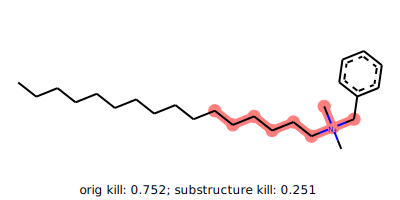

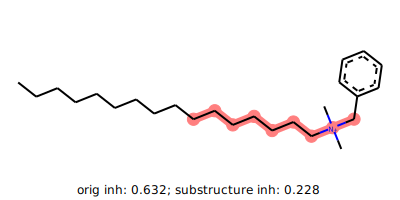


-----------------------------------------------------------------------
domiphen , actual kill:  1.0 , actual inh:  1.0


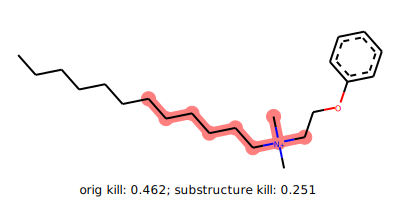

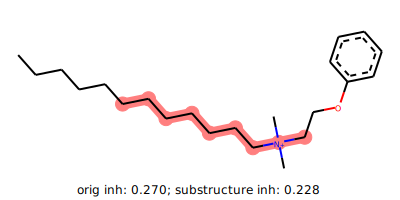


-----------------------------------------------------------------------
amiselimod , actual kill:  1.0 , actual inh:  1.0


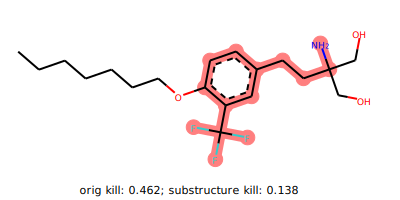

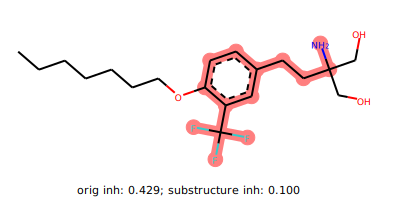


-----------------------------------------------------------------------
silver-sulfadiazine , actual kill:  1.0 , actual inh:  1.0


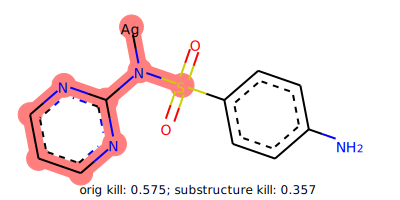

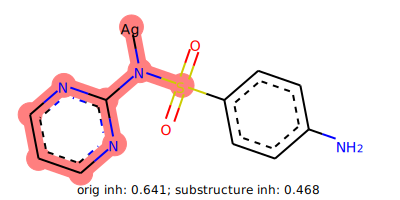


-----------------------------------------------------------------------
benzethonium , actual kill:  1.0 , actual inh:  1.0


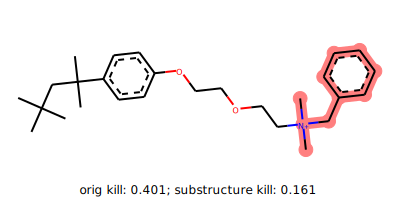

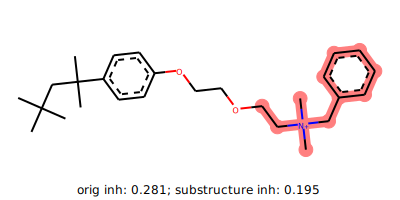


-----------------------------------------------------------------------
visomitin , actual kill:  1.0 , actual inh:  1.0


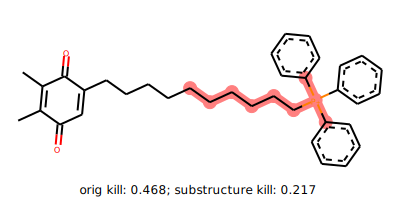

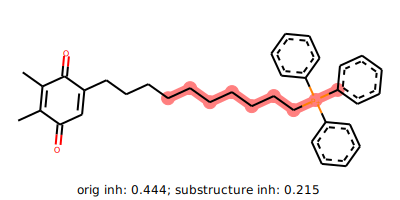


-----------------------------------------------------------------------
semapimod , actual kill:  1.0 , actual inh:  1.0


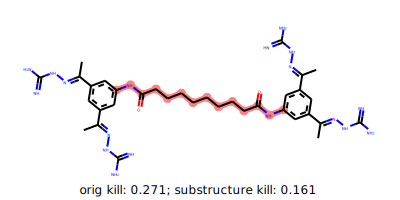

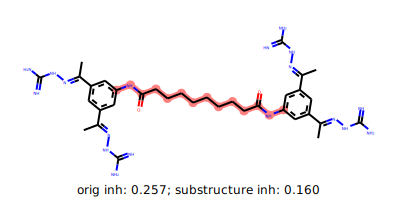


-----------------------------------------------------------------------
thonzonium , actual kill:  1.0 , actual inh:  0.0


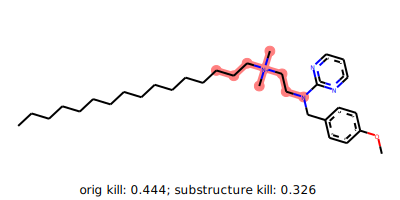

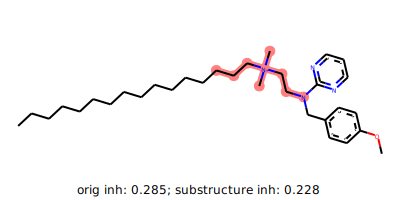


-----------------------------------------------------------------------
TAK-779 , actual kill:  1.0 , actual inh:  0.0


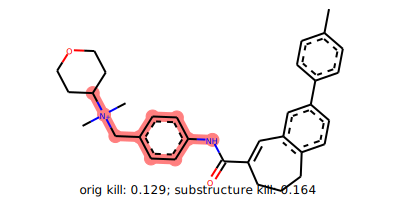

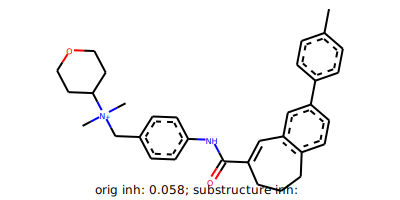


-----------------------------------------------------------------------
NPS-2143 , actual kill:  1.0 , actual inh:  0.0


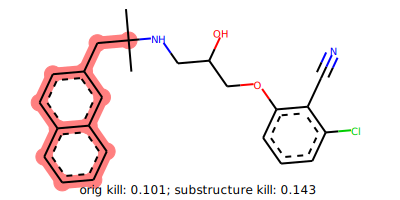

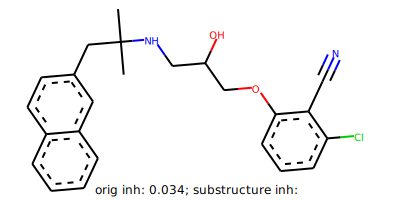


-----------------------------------------------------------------------
D-3263 , actual kill:  1.0 , actual inh:  1.0


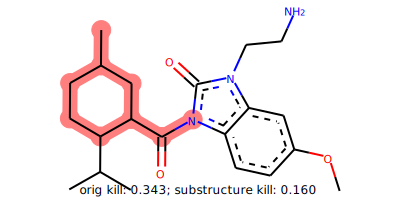

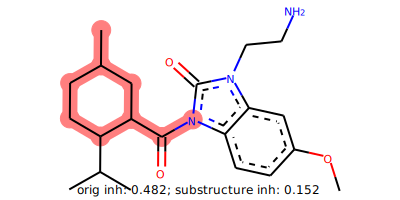


-----------------------------------------------------------------------
cetylpyridinium , actual kill:  1.0 , actual inh:  1.0


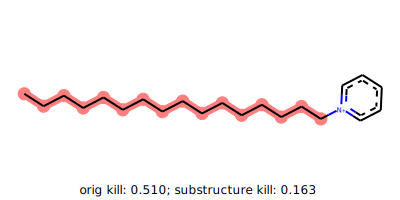

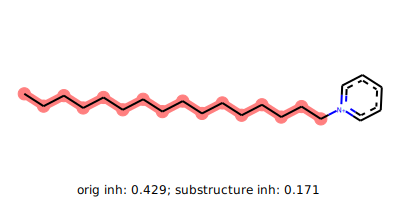


-----------------------------------------------------------------------
thiomersal , actual kill:  1.0 , actual inh:  1.0


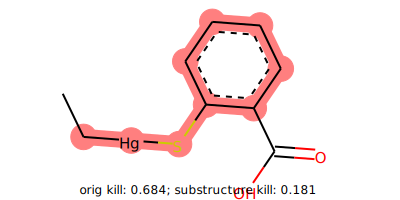

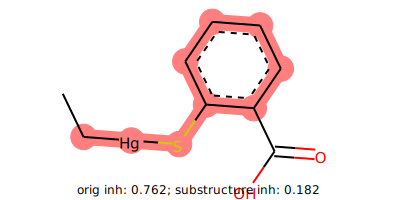


-----------------------------------------------------------------------
sertraline , actual kill:  1.0 , actual inh:  1.0


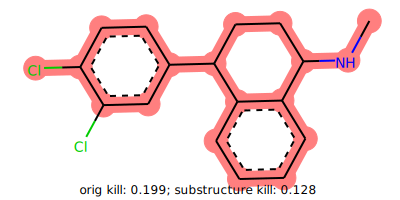

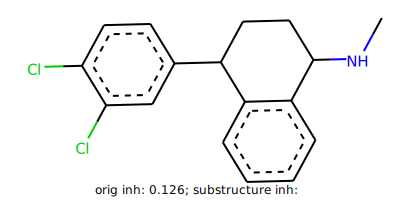


-----------------------------------------------------------------------
NH125 , actual kill:  1.0 , actual inh:  1.0


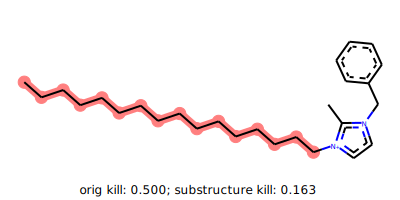

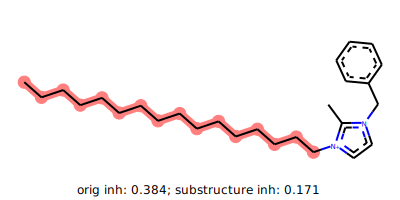


-----------------------------------------------------------------------
wiskostatin , actual kill:  1.0 , actual inh:  0.0


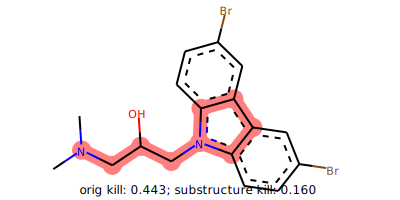

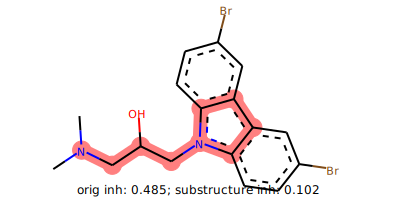


-----------------------------------------------------------------------
mitomycin-C , actual kill:  1.0 , actual inh:  1.0


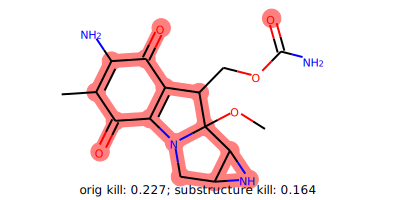

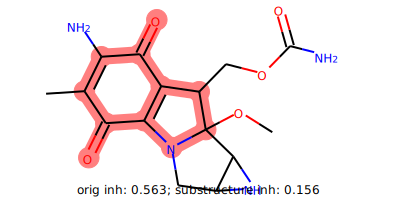


-----------------------------------------------------------------------
tolonium , actual kill:  1.0 , actual inh:  0.0


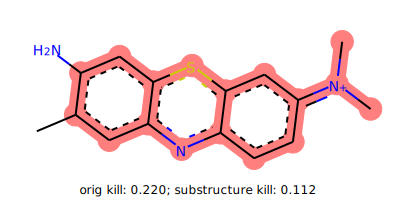

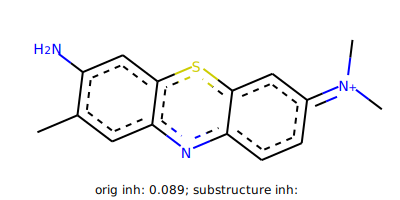


-----------------------------------------------------------------------
decamethoxine , actual kill:  1.0 , actual inh:  1.0


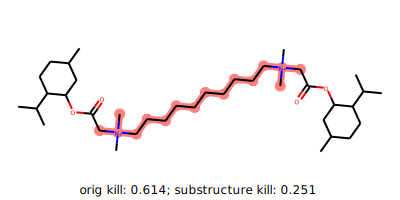

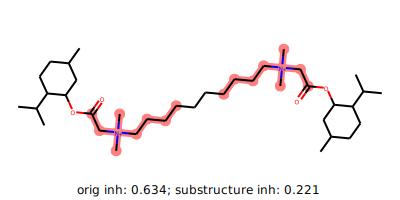


-----------------------------------------------------------------------
hexachlorophene , actual kill:  1.0 , actual inh:  1.0


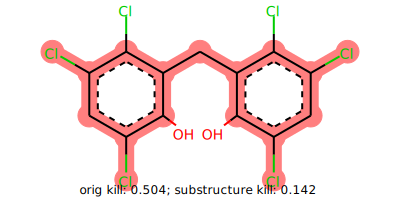

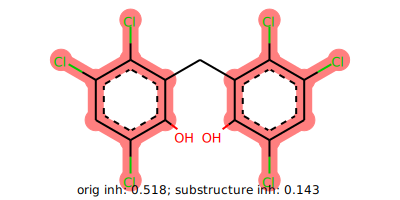


-----------------------------------------------------------------------
BAX-channel-blocker , actual kill:  1.0 , actual inh:  1.0


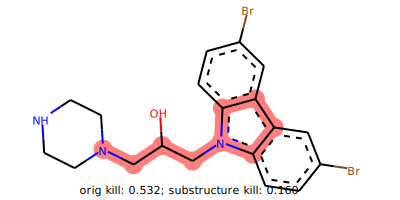

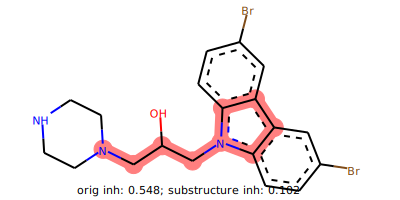


-----------------------------------------------------------------------
methylene-blue , actual kill:  1.0 , actual inh:  0.0


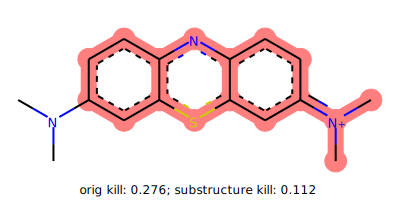

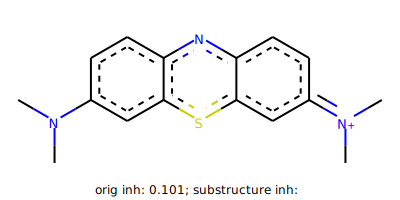


-----------------------------------------------------------------------
stattic , actual kill:  1.0 , actual inh:  1.0


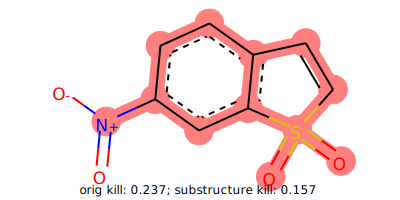

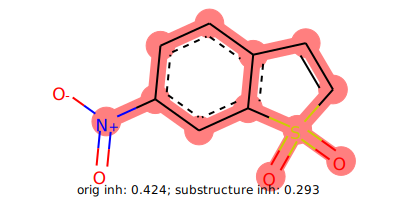


-----------------------------------------------------------------------
acriflavinium , actual kill:  1.0 , actual inh:  0.0


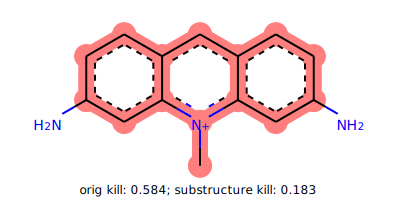

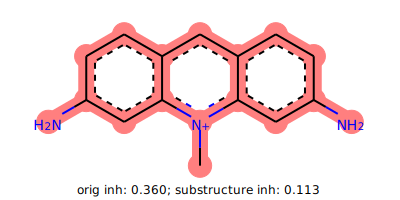


-----------------------------------------------------------------------
2-deoxy-2-([methyl(nitroso)carbamoyl]amino)hexose , actual kill:  1.0 , actual inh:  0.0


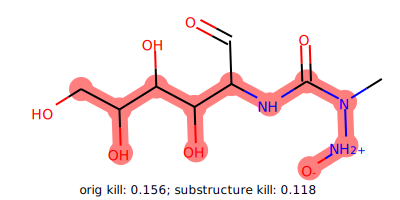

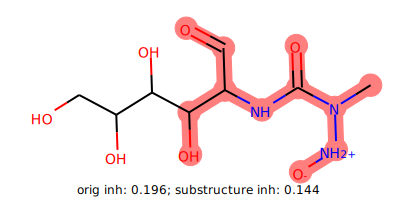


-----------------------------------------------------------------------
acriflavine , actual kill:  1.0 , actual inh:  0.0


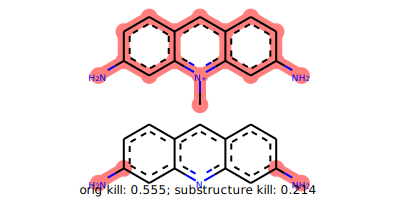

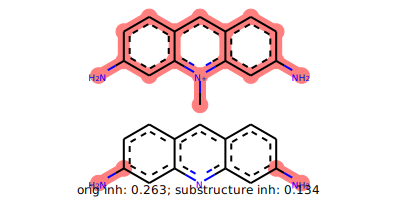


-----------------------------------------------------------------------
mitoquinone , actual kill:  1.0 , actual inh:  1.0


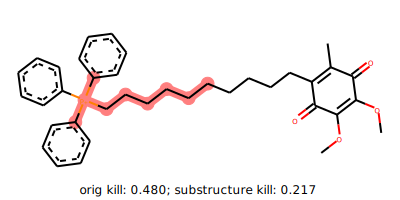

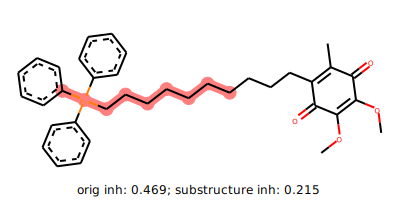


-----------------------------------------------------------------------
satraplatin , actual kill:  1.0 , actual inh:  0.0


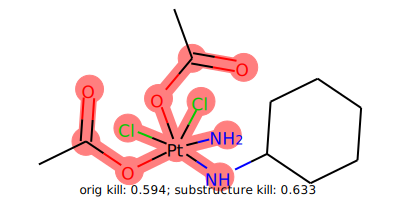

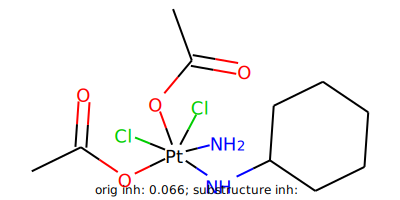


-----------------------------------------------------------------------
eravacycline , actual kill:  1.0 , actual inh:  1.0


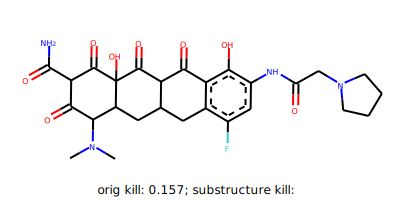

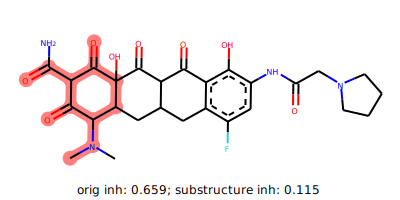


-----------------------------------------------------------------------
sanguinarium-chloride , actual kill:  1.0 , actual inh:  0.0


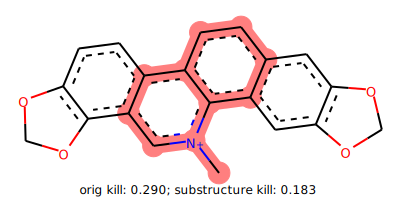

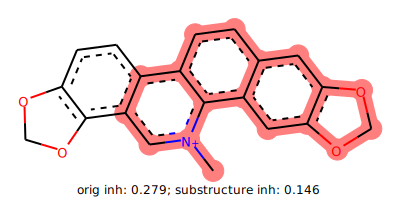


-----------------------------------------------------------------------
delafloxacin , actual kill:  1.0 , actual inh:  1.0


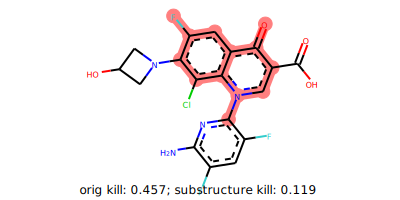

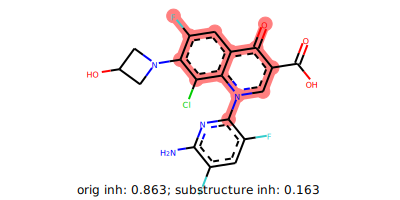


-----------------------------------------------------------------------
SU3327 , actual kill:  1.0 , actual inh:  1.0


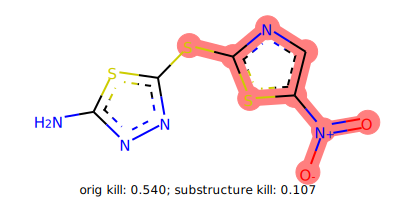

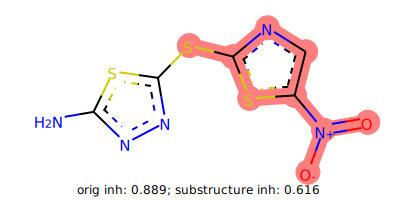


-----------------------------------------------------------------------
ozenoxacin , actual kill:  1.0 , actual inh:  1.0


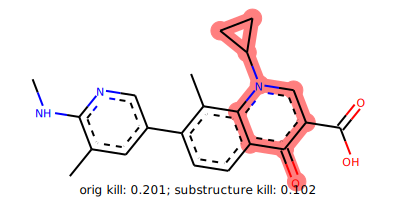

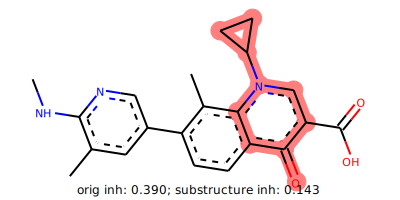


-----------------------------------------------------------------------
clinafloxacin , actual kill:  1.0 , actual inh:  1.0


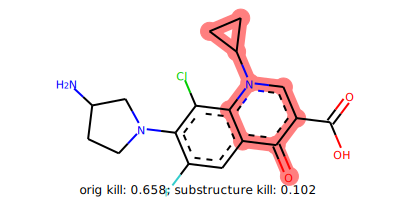

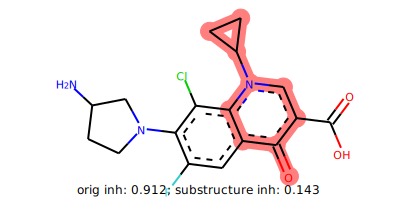


-----------------------------------------------------------------------
tosufloxacin , actual kill:  1.0 , actual inh:  1.0


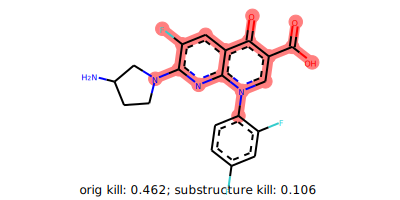

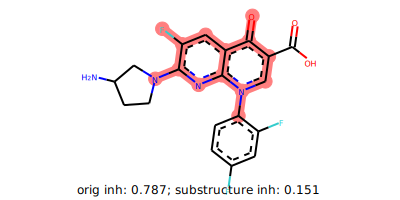


-----------------------------------------------------------------------
gatifloxacin , actual kill:  1.0 , actual inh:  1.0


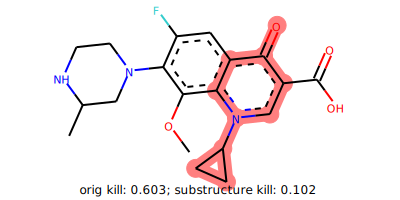

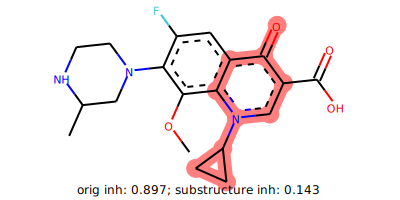


-----------------------------------------------------------------------
trovafloxacin , actual kill:  1.0 , actual inh:  1.0


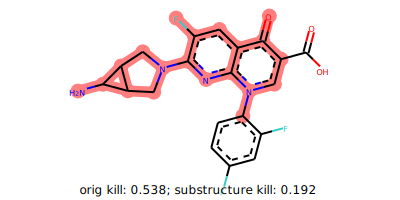

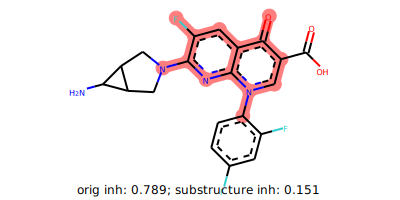


-----------------------------------------------------------------------
moxifloxacin , actual kill:  1.0 , actual inh:  1.0


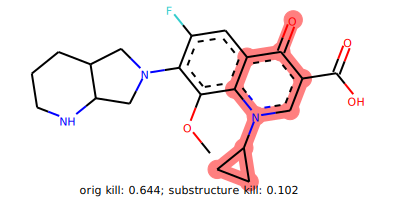

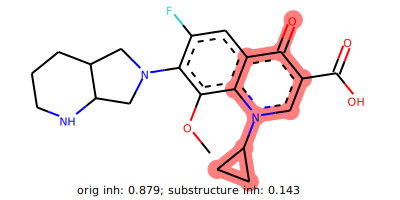


-----------------------------------------------------------------------
garenoxacin , actual kill:  1.0 , actual inh:  1.0


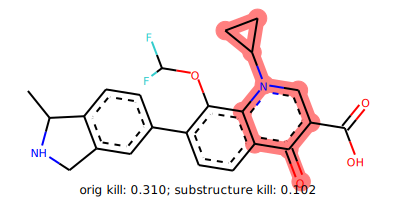

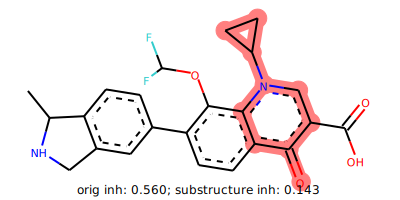


-----------------------------------------------------------------------
norfloxacin , actual kill:  1.0 , actual inh:  1.0


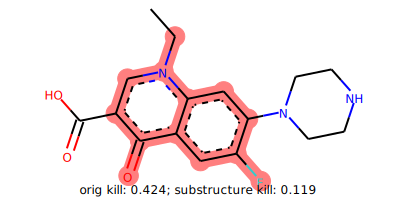

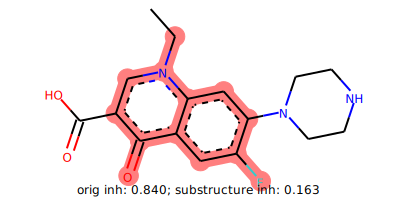


-----------------------------------------------------------------------
tetrindole , actual kill:  1.0 , actual inh:  1.0


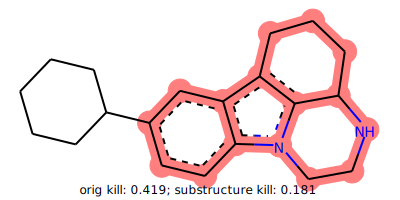

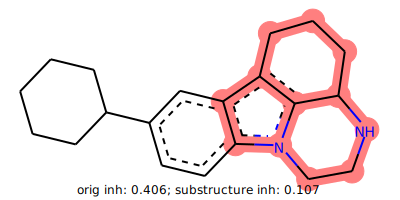


-----------------------------------------------------------------------
difloxacin , actual kill:  1.0 , actual inh:  1.0


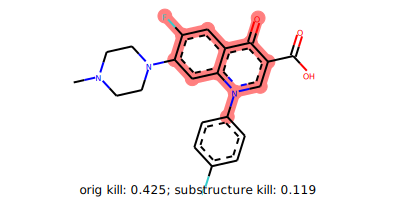

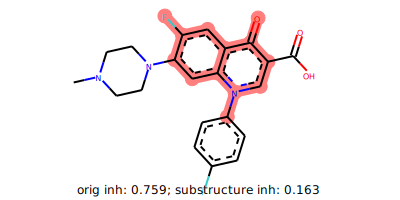


-----------------------------------------------------------------------
sarafloxacin , actual kill:  1.0 , actual inh:  1.0


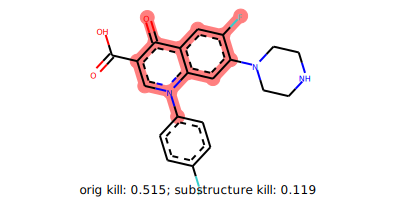

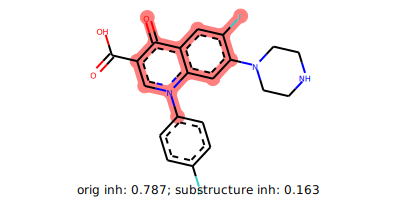


-----------------------------------------------------------------------
levofloxacin , actual kill:  1.0 , actual inh:  1.0


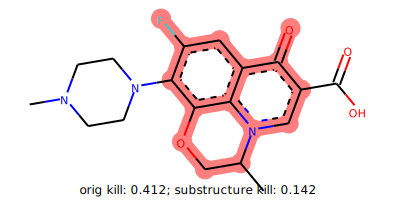

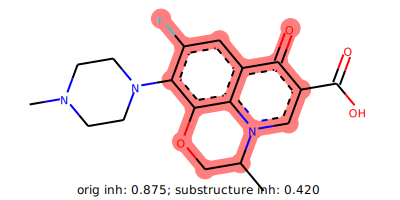

In [4]:
for i, line in merged_df.iterrows():
    
    name = line['Name']
    actual_kill = line['hit_kill']
    actual_inh = line['hit_inh']
    
    orig_smi = line['original_mol']
    orig_kill_sco = line['orig_kill_score']
    kill_rat_smi = line['kill_rationale']
    kill_rat_sco = line['kill_rationale_score']
    orig_inh_sco = line['orig_inh_score']
    inh_rat_smi = line['inh_rationale']
    inh_rat_sco = line['inh_rationale_score']    


    if inh_rat_sco != '' or kill_rat_sco != '':
        print('')
        print('-----------------------------------------------------------------------')
        print(name, ', actual kill: ', actual_kill, ', actual inh: ', actual_inh)

        img = SVG(increase_resolution(orig_smi, kill_rat_smi, kekulize=True, legend = 'orig kill: ' + str(orig_kill_sco) + '; substructure kill: ' + str(kill_rat_sco)))
        
        display(img)

        img = SVG(increase_resolution(orig_smi, inh_rat_smi, kekulize=True, legend = 'orig inh: ' + str(orig_inh_sco) + '; substructure inh: ' + str(inh_rat_sco)))
        display(img)